# Лабораторная работа №3. Бинарная сегментация избражений

В работе реализована тренировка сверточной нейронной сети Unet для сегментации левого желудочка на УЗИ изображениях сердца.

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import random
import datetime
import pandas as pd
import torch
from torch.utils import data
import segmentation_models_pytorch as smp
from torch import nn 
import torch.nn.functional as F
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Директория датасета состоит из двух директорий, в одной лежат изображения, в другой лежат разметка.

In [2]:
path = r'D:\public_notebook_server\segmentation\segmentation\ultrasound'
os.listdir(path)

['images', 'labels']

Необходимо собрать все изображения и разметки из директорий

In [3]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    elif folder == 'labels':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

Проверим, что названия в папке images и labels совпадают.

In [4]:
for img_pth, lbl_pth in zip(img_pathes, lbl_pathes):
    if os.path.join(*img_pth.split('\\')[-3:]) != os.path.join(*lbl_pth.split('\\')[-3:]):
        print('Каталоги не одинаковые')
        break

Реализуем класс Dataset

In [5]:
T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images':
                img_pathes = pathes
            elif folder == 'labels':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

Визаулизируем УЗИ-кадры и бинарные маски для кадров.

In [6]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)
test_data = Dataset(path, subset='test', transform=T)

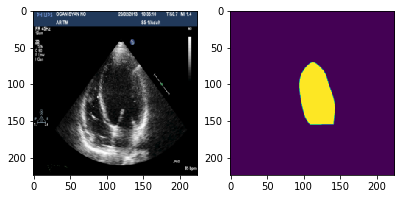

In [7]:
img, msk = train_data[0]
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(msk.squeeze().numpy())

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False)

Используем модель Unet для сегментации снимков из библиотеки segmentation_models (https://github.com/qubvel/segmentation_models.pytorch).

In [9]:
model = smp.Unet().to(device)

Определяем функцию ошибки бинарную кроссэнтропию. Установи шаг обучения для энкодера и декодера сети, причем энкодер будет обучать медленнее.

In [10]:
loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

In [11]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)


In [12]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou']:
#         max_score = valid_logs['iou']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████████████████████| 3/3 [00:02<00:00,  1.14it/s, bce_loss - 1.532, iou - 0.05857, f-score - 0.1106]

Epoch: 1
valid: 100%|██████████████████████████| 3/3 [00:00<00:00,  8.75it/s, bce_loss - 0.3152, iou - 0.5027, f-score - 0.6678]

Epoch: 2
valid: 100%|███████████████████████████| 3/3 [00:00<00:00,  8.75it/s, bce_loss - 0.177, iou - 0.7078, f-score - 0.8288]

Epoch: 3
valid: 100%|██████████████████████████| 3/3 [00:00<00:00,  8.78it/s, bce_loss - 0.1429, iou - 0.7346, f-score - 0.8469]

Epoch: 4
valid: 100%|███████████████████████████| 3/3 [00:00<00:00,  8.70it/s, bce_loss - 0.1257, iou - 0.7123, f-score - 0.832]

Epoch: 5
valid: 100%|██████████████████████████| 3/3 [00:00<00:00,  8.78it/s, bce_loss - 0.1164, iou - 0.7371, f-score - 0.8487]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████████████████████| 3/3 [00:00<00:00,  8.83it/s, bce_loss - 0.1144, iou - 0.7678, f-score - 0.8686]

Epoch: 7
valid: 100%|██████████████████████████| 

In [13]:
valid_epoch.run(test_loader)

valid: 100%|████████████████████████| 19/19 [00:02<00:00,  9.49it/s, bce_loss - 0.1162, iou - 0.7599, f-score - 0.8595]


{'bce_loss': 0.11621684188905515,
 'f-score': 0.8595486220560574,
 'iou': 0.7598692241467928}

Максимальное значение на валидации iou метрики - 77% и f-score - 87%. На тесте iou - 77%, f-score - 86%.

Возьмем другую функцию ошибки Dice и построим модель сегментации.

In [14]:
model = smp.Unet().to(device)

loss = smp.utils.losses.BCEDiceLoss(eps=1.)

metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [15]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou']:
#         max_score = valid_logs['iou']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|█████████████████████| 3/3 [00:00<00:00,  8.75it/s, bce_dice_loss - 2.401, iou - 0.06102, f-score - 0.1149]

Epoch: 1
valid: 100%|██████████████████████| 3/3 [00:00<00:00,  8.46it/s, bce_dice_loss - 1.538, iou - 0.1728, f-score - 0.2937]

Epoch: 2
valid: 100%|███████████████████████| 3/3 [00:00<00:00,  8.29it/s, bce_dice_loss - 1.208, iou - 0.5402, f-score - 0.699]

Epoch: 3
valid: 100%|██████████████████████| 3/3 [00:00<00:00,  8.73it/s, bce_dice_loss - 1.117, iou - 0.7337, f-score - 0.8464]

Epoch: 4
valid: 100%|████████████████████████| 3/3 [00:00<00:00,  8.73it/s, bce_dice_loss - 1.1, iou - 0.6998, f-score - 0.8232]

Epoch: 5
valid: 100%|███████████████████████| 3/3 [00:00<00:00,  8.73it/s, bce_dice_loss - 1.104, iou - 0.631, f-score - 0.7732]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████████████████| 3/3 [00:00<00:00,  8.73it/s, bce_dice_loss - 1.082, iou - 0.7108, f-score - 0.8309]

Epoch: 7
valid: 100%|███████████████████████| 3/3

In [16]:
valid_epoch.run(test_loader)

valid: 100%|█████████████████████| 19/19 [00:00<00:00, 29.07it/s, bce_dice_loss - 1.051, iou - 0.772, f-score - 0.8667]


{'bce_dice_loss': 1.051064714005119,
 'f-score': 0.8667368010470743,
 'iou': 0.7719768285751343}

Максимальное значение на валидации iou метрики - 79% и f-score - 88%. На тесте iou - 78%, f-score - 88%.

In [17]:
img, mask_true = test_data[0]
mask_pred = F.sigmoid(model(img.unsqueeze(0).to(device)))

D:\Anaconda\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


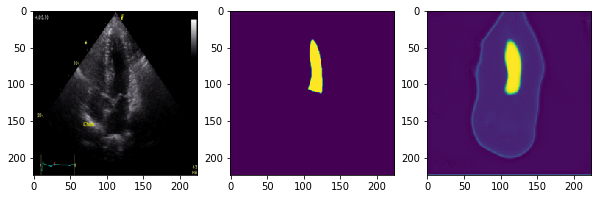

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(mask_true.squeeze().numpy())
plt.subplot(133)
plt.imshow(mask_pred.squeeze().cpu().detach().numpy())

# Задача

Натренировать Unet для сегментации людей на изображении. Использовать датасет 'person segmentation' по ссылке https://drive.google.com/open?id=1yi7Flk_Whidr2OZNdfmGkpgxbQPwIVtr.
Натрениройте несколько моделей Unet с различными энкодерами, проведите анализ качества полученных моделей. Сведите результаты в таблицу по всем моделям и для каждой подвиборке (train, valid, test). Приведите примеры кадров с людьми.

In [19]:
path = r'D:\public_notebook_server\segmentation\segmentation\person_segmentation\train'
os.listdir(path)

['images', 'masks']

In [20]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    elif folder == 'masks':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [21]:
for img_pth, lbl_pth in zip(img_pathes, lbl_pathes):
    if os.path.splitext(os.path.basename(img_pth))[-2] != os.path.splitext(os.path.basename(lbl_pth))[-2]:
        print('Каталоги не одинаковые')
        break

In [22]:
T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images':
                img_pathes = pathes
            elif folder == 'masks':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [23]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)
test_data = Dataset(path, subset='test', transform=T)

114


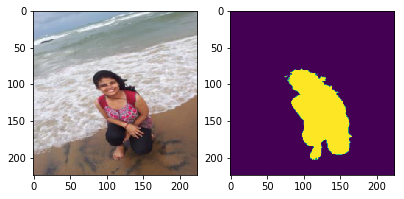

In [24]:
indx=random.randint(0,len(test_data)-1)
print(indx)
img, msk = test_data[indx]
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(msk.squeeze().numpy())

In [25]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False)

In [41]:
lr_results={}

# Unet | BCE | decoder lr 1e-3->1e-5 encoder lr 1e-5

In [42]:
model = smp.Unet().to(device)

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

lr='d 1e-3->1e-5 e 1e-5'

lr_results[lr]={}

start_dttm=datetime.datetime.now()

scores=[]

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
               
    scores.append({'train':train_logs,'valid':valid_logs})
      
lr_results[lr]['time']=str(datetime.datetime.now()-start_dttm)

lr_results[lr]['epochs']=scores

with torch.no_grad():
    lr_results[lr]['test']=valid_epoch.run(test_loader)

img, mask_true = test_data[indx]

lr_results[lr]['pred'] = F.sigmoid(model(img.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()

valid_epoch.run(test_loader)


Epoch: 0
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.88it/s, bce_loss - 0.1601, iou - 0.9197, f-score - 0.9581]

Epoch: 1
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.59it/s, bce_loss - 0.1168, iou - 0.9417, f-score - 0.9699]

Epoch: 2
valid: 100%|███████████████████████| 19/19 [00:02<00:00,  8.98it/s, bce_loss - 0.09263, iou - 0.9476, f-score - 0.9731]

Epoch: 3
valid: 100%|███████████████████████| 19/19 [00:02<00:00,  8.95it/s, bce_loss - 0.09091, iou - 0.9477, f-score - 0.9731]

Epoch: 4
valid: 100%|███████████████████████| 19/19 [00:02<00:00,  8.95it/s, bce_loss - 0.09364, iou - 0.9467, f-score - 0.9726]

Epoch: 5
valid: 100%|███████████████████████| 19/19 [00:02<00:00,  8.95it/s, bce_loss - 0.08701, iou - 0.9499, f-score - 0.9743]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|███████████████████████| 19/19 [00:02<00:00,  8.94it/s, bce_loss - 0.08092, iou - 0.9523, f-score - 0.9755]

Epoch: 7
valid: 100%|████████████████████████| 19

D:\Anaconda\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|█████████████████████| 150/150 [00:04<00:00, 31.95it/s, bce_loss - 0.07459, iou - 0.9548, f-score - 0.9765]


{'bce_loss': 0.07458669700970254,
 'f-score': 0.9764907920360567,
 'iou': 0.9547837313016251}

# Unet | BCE | decoder lr 1e-3 encoder lr 1e-5

In [43]:
model = smp.Unet().to(device)

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

lr='d 1e-3 e 1e-5'

lr_results[lr]={}

start_dttm=datetime.datetime.now()

scores=[]

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    scores.append({'train':train_logs,'valid':valid_logs})
      
lr_results[lr]['time']=str(datetime.datetime.now()-start_dttm)

lr_results[lr]['epochs']=scores

with torch.no_grad():
    lr_results[lr]['test']=valid_epoch.run(test_loader)

img, mask_true = test_data[indx]

lr_results[lr]['pred'] = F.sigmoid(model(img.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    
valid_epoch.run(test_loader)


Epoch: 0
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.94it/s, bce_loss - 0.1874, iou - 0.9152, f-score - 0.9556]

Epoch: 1
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.88it/s, bce_loss - 0.1243, iou - 0.9404, f-score - 0.9692]

Epoch: 2
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.94it/s, bce_loss - 0.1081, iou - 0.9432, f-score - 0.9707]

Epoch: 3
valid: 100%|███████████████████████| 19/19 [00:02<00:00,  8.93it/s, bce_loss - 0.09731, iou - 0.9446, f-score - 0.9715]

Epoch: 4
valid: 100%|███████████████████████| 19/19 [00:02<00:00,  8.94it/s, bce_loss - 0.09976, iou - 0.9463, f-score - 0.9724]

Epoch: 5
valid: 100%|███████████████████████| 19/19 [00:02<00:00,  8.94it/s, bce_loss - 0.08954, iou - 0.9496, f-score - 0.9741]

Epoch: 6
valid: 100%|███████████████████████| 19/19 [00:02<00:00,  8.84it/s, bce_loss - 0.08808, iou - 0.9506, f-score - 0.9746]

Epoch: 7
valid: 100%|███████████████████████| 19/19 [00:02<00:00,  8.90it/s, bce_loss - 0

D:\Anaconda\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|█████████████████████| 150/150 [00:04<00:00, 31.85it/s, bce_loss - 0.08226, iou - 0.9565, f-score - 0.9773]


{'bce_loss': 0.08226074968775113,
 'f-score': 0.9773413888613381,
 'iou': 0.9564746499061585}

# Unet | BCE | decoder lr 1e-5 encoder lr 1e-5

In [44]:
model = smp.Unet().to(device)

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-5},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

lr='d 1e-5 e 1e-5'

lr_results[lr]={}

start_dttm=datetime.datetime.now()

scores=[]

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    scores.append({'train':train_logs,'valid':valid_logs})
      
lr_results[lr]['time']=str(datetime.datetime.now()-start_dttm)

lr_results[lr]['epochs']=scores

with torch.no_grad():
    lr_results[lr]['test']=valid_epoch.run(test_loader)

img, mask_true = test_data[indx]

lr_results[lr]['pred'] = F.sigmoid(model(img.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    
valid_epoch.run(test_loader)


Epoch: 0
valid: 100%|█████████████████████████| 19/19 [00:02<00:00,  8.93it/s, bce_loss - 0.493, iou - 0.6692, f-score - 0.8017]

Epoch: 1
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.89it/s, bce_loss - 0.3852, iou - 0.7728, f-score - 0.8717]

Epoch: 2
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.93it/s, bce_loss - 0.3189, iou - 0.8263, f-score - 0.9048]

Epoch: 3
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.10it/s, bce_loss - 0.2684, iou - 0.8694, f-score - 0.9301]

Epoch: 4
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.90it/s, bce_loss - 0.2279, iou - 0.8973, f-score - 0.9459]

Epoch: 5
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.90it/s, bce_loss - 0.2087, iou - 0.9089, f-score - 0.9522]

Epoch: 6
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.88it/s, bce_loss - 0.1959, iou - 0.9149, f-score - 0.9555]

Epoch: 7
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.90it/s, bce_loss - 

D:\Anaconda\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|███████████████████████| 150/150 [00:04<00:00, 32.04it/s, bce_loss - 0.133, iou - 0.9343, f-score - 0.9651]


{'bce_loss': 0.1329723758995534,
 'f-score': 0.9650675125916803,
 'iou': 0.9342807360490161}

# Unet | BCE | decoder lr 1e-3 encoder lr 1e-3

In [45]:
model = smp.Unet().to(device)

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

lr='d 1e-3 e 1e-3'

lr_results[lr]={}

start_dttm=datetime.datetime.now()

scores=[]

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    scores.append({'train':train_logs,'valid':valid_logs})
      
lr_results[lr]['time']=str(datetime.datetime.now()-start_dttm)

lr_results[lr]['epochs']=scores

with torch.no_grad():
    lr_results[lr]['test']=valid_epoch.run(test_loader)

img, mask_true = test_data[indx]

lr_results[lr]['pred'] = F.sigmoid(model(img.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    
valid_epoch.run(test_loader)


Epoch: 0
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.95it/s, bce_loss - 0.1922, iou - 0.8917, f-score - 0.9426]

Epoch: 1
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.95it/s, bce_loss - 0.1812, iou - 0.8976, f-score - 0.9459]

Epoch: 2
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.93it/s, bce_loss - 0.1745, iou - 0.9007, f-score - 0.9477]

Epoch: 3
valid: 100%|█████████████████████████| 19/19 [00:02<00:00,  8.91it/s, bce_loss - 0.165, iou - 0.9065, f-score - 0.9508]

Epoch: 4
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.95it/s, bce_loss - 0.1362, iou - 0.9208, f-score - 0.9587]

Epoch: 5
valid: 100%|██████████████████████████| 19/19 [00:02<00:00,  8.93it/s, bce_loss - 0.132, iou - 0.927, f-score - 0.9621]

Epoch: 6
valid: 100%|█████████████████████████| 19/19 [00:02<00:00,  8.95it/s, bce_loss - 0.122, iou - 0.9284, f-score - 0.9628]

Epoch: 7
valid: 100%|████████████████████████| 19/19 [00:02<00:00,  8.58it/s, bce_loss - 

D:\Anaconda\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|███████████████████████| 150/150 [00:04<00:00, 31.87it/s, bce_loss - 0.1087, iou - 0.934, f-score - 0.9647]


{'bce_loss': 0.1087406297462682,
 'f-score': 0.9647467652956646,
 'iou': 0.9339744170506793}

# Unet | DICE | decoder lr 1e-3 encoder lr 1e-5

In [46]:
model = smp.Unet().to(device)

loss = smp.utils.losses.BCEDiceLoss(eps=1.)

metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
        
valid_epoch.run(test_loader)


Epoch: 0
valid: 100%|███████████████████| 19/19 [00:02<00:00,  8.90it/s, bce_dice_loss - 0.2282, iou - 0.9275, f-score - 0.9624]

Epoch: 1
valid: 100%|████████████████████| 19/19 [00:02<00:00,  8.89it/s, bce_dice_loss - 0.1642, iou - 0.943, f-score - 0.9706]

Epoch: 2
valid: 100%|████████████████████| 19/19 [00:02<00:00,  8.86it/s, bce_dice_loss - 0.156, iou - 0.9417, f-score - 0.9699]

Epoch: 3
valid: 100%|████████████████████| 19/19 [00:02<00:00,  8.77it/s, bce_dice_loss - 0.132, iou - 0.9479, f-score - 0.9733]

Epoch: 4
valid: 100%|███████████████████| 19/19 [00:02<00:00,  8.88it/s, bce_dice_loss - 0.1312, iou - 0.9505, f-score - 0.9746]

Epoch: 5
valid: 100%|███████████████████| 19/19 [00:02<00:00,  8.88it/s, bce_dice_loss - 0.1273, iou - 0.9497, f-score - 0.9742]

Epoch: 6
valid: 100%|████████████████████| 19/19 [00:02<00:00,  8.89it/s, bce_dice_loss - 0.118, iou - 0.9525, f-score - 0.9756]

Epoch: 7
valid: 100%|███████████████████| 19/19 [00:02<00:00,  8.90it/s, bce_dice_loss - 

{'bce_dice_loss': 0.10805626049637794,
 'f-score': 0.9785891203085579,
 'iou': 0.9587311371167498}

# encoders

In [31]:
results={}

In [32]:
for encoder in [
                'vgg11','vgg16','vgg19',
                'densenet121','densenet201',
                'inceptionresnetv2',
                'resnet18','resnet50','resnet152'
               ]:
    
    print(encoder)
    torch.cuda.empty_cache()
    
    model = smp.Unet(encoder).to(device)    
   
    loss = smp.utils.losses.BCEDiceLoss(eps=1.)

    metrics = [
        smp.utils.metrics.IoUMetric(eps=1.),
        smp.utils.metrics.FscoreMetric(eps=1.),
    ]

    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters(), 'lr': 1e-3},     

        {'params': model.encoder.parameters(), 'lr': 1e-5},  
    ])

    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=True,
    )
    
    results[encoder]={}
    
    start_dttm=datetime.datetime.now()
    
    scores=[]
    
    for i in range(0, 20):
        torch.cuda.empty_cache()        
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        with torch.no_grad():
            valid_logs = valid_epoch.run(valid_loader)
        
        scores.append({'train':train_logs,'valid':valid_logs})
      
    results[encoder]['time']=str(datetime.datetime.now()-start_dttm)
    
    results[encoder]['epochs']=scores
    
    with torch.no_grad():
        results[encoder]['test']=valid_epoch.run(test_loader)
    
    img, mask_true = test_data[indx]
    
    results[encoder]['pred'] = F.sigmoid(model(img.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    
    model=model.cpu()
    loss=loss.cpu()
    metrics[0]=metrics[0].cpu()
    metrics[1]=metrics[1].cpu()
    del model, loss, train_epoch, valid_epoch, optimizer, metrics
    torch.cuda.empty_cache() 

vgg11

Epoch: 0
valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.92it/s, bce_dice_loss - 0.2649, iou - 0.9134, f-score - 0.9547]

Epoch: 1
valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.89it/s, bce_dice_loss - 0.2063, iou - 0.9263, f-score - 0.9617]

Epoch: 2
valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.91it/s, bce_dice_loss - 0.1932, iou - 0.9257, f-score - 0.9613]

Epoch: 3
valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.89it/s, bce_dice_loss - 0.1674, iou - 0.9338, f-score - 0.9658]

Epoch: 4
valid: 100%|████████████████████| 19/19 [00:02<00:00,  7.91it/s, bce_dice_loss - 0.1609, iou - 0.9363, f-score - 0.967]

Epoch: 5
valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.90it/s, bce_dice_loss - 0.1735, iou - 0.9351, f-score - 0.9664]

Epoch: 6
valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.90it/s, bce_dice_loss - 0.1638, iou - 0.9386, f-score - 0.9683]

Epoch: 7
valid: 100%|█████████████████████| 19/19 [00:03<00:00,  5.71it/s, bce_dice

D:\Anaconda\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


vgg16

Epoch: 0
valid: 100%|███████████████████| 19/19 [00:02<00:00,  6.46it/s, bce_dice_loss - 0.3321, iou - 0.9267, f-score - 0.9619]

Epoch: 1
valid: 100%|███████████████████| 19/19 [00:02<00:00,  6.45it/s, bce_dice_loss - 0.2431, iou - 0.9365, f-score - 0.9672]

Epoch: 2
valid: 100%|████████████████████| 19/19 [00:02<00:00,  6.45it/s, bce_dice_loss - 0.187, iou - 0.9393, f-score - 0.9687]

Epoch: 3
valid: 100%|█████████████████████| 19/19 [00:02<00:00,  6.47it/s, bce_dice_loss - 0.155, iou - 0.948, f-score - 0.9733]

Epoch: 4
valid: 100%|███████████████████| 19/19 [00:02<00:00,  6.46it/s, bce_dice_loss - 0.1403, iou - 0.9485, f-score - 0.9735]

Epoch: 5
valid: 100%|████████████████████| 19/19 [00:02<00:00,  6.36it/s, bce_dice_loss - 0.143, iou - 0.9485, f-score - 0.9735]

Epoch: 6
valid: 100%|███████████████████| 19/19 [00:02<00:00,  6.46it/s, bce_dice_loss - 0.1398, iou - 0.9486, f-score - 0.9736]

Epoch: 7
valid: 100%|████████████████████| 19/19 [00:02<00:00,  6.46it/s, bce_dice_

valid: 100%|███████████████████| 19/19 [00:03<00:00,  5.97it/s, bce_dice_loss - 0.1385, iou - 0.9519, f-score - 0.9753]

Epoch: 13
valid: 100%|████████████████████| 19/19 [00:03<00:00,  5.99it/s, bce_dice_loss - 0.1408, iou - 0.9513, f-score - 0.975]

Epoch: 14
valid: 100%|███████████████████| 19/19 [00:03<00:00,  5.98it/s, bce_dice_loss - 0.1367, iou - 0.9534, f-score - 0.9761]

Epoch: 15
valid: 100%|████████████████████| 19/19 [00:03<00:00,  5.99it/s, bce_dice_loss - 0.1427, iou - 0.953, f-score - 0.9759]

Epoch: 16
valid: 100%|████████████████████| 19/19 [00:03<00:00,  5.96it/s, bce_dice_loss - 0.1378, iou - 0.954, f-score - 0.9764]

Epoch: 17
valid: 100%|████████████████████| 19/19 [00:03<00:00,  5.98it/s, bce_dice_loss - 0.1478, iou - 0.953, f-score - 0.9759]

Epoch: 18
valid: 100%|███████████████████| 19/19 [00:03<00:00,  5.99it/s, bce_dice_loss - 0.1464, iou - 0.9502, f-score - 0.9744]

Epoch: 19
valid: 100%|█████████████████| 150/150 [00:03<00:00, 45.98it/s, bce_dice_loss - 0.1

valid: 100%|███████████████████| 19/19 [00:03<00:00,  5.19it/s, bce_dice_loss - 0.1441, iou - 0.9469, f-score - 0.9727]

Epoch: 4
valid: 100%|████████████████████| 19/19 [00:03<00:00,  5.20it/s, bce_dice_loss - 0.1333, iou - 0.949, f-score - 0.9738]

Epoch: 5
valid: 100%|███████████████████| 19/19 [00:03<00:00,  5.19it/s, bce_dice_loss - 0.1232, iou - 0.9518, f-score - 0.9753]

Epoch: 6
valid: 100%|█████████████████████| 19/19 [00:03<00:00,  5.19it/s, bce_dice_loss - 0.119, iou - 0.9531, f-score - 0.976]

Epoch: 7
valid: 100%|███████████████████| 19/19 [00:03<00:00,  5.17it/s, bce_dice_loss - 0.1159, iou - 0.9548, f-score - 0.9769]

Epoch: 8
valid: 100%|█████████████████████| 19/19 [00:03<00:00,  5.17it/s, bce_dice_loss - 0.113, iou - 0.956, f-score - 0.9775]

Epoch: 9
valid: 100%|█████████████████████| 19/19 [00:03<00:00,  5.18it/s, bce_dice_loss - 0.1114, iou - 0.957, f-score - 0.978]

Epoch: 10
valid: 100%|███████████████████| 19/19 [00:03<00:00,  5.19it/s, bce_dice_loss - 0.1134, i

valid: 100%|███████████████████| 19/19 [00:03<00:00,  4.93it/s, bce_dice_loss - 0.1317, iou - 0.9483, f-score - 0.9734]

Epoch: 16
valid: 100%|████████████████████| 19/19 [00:03<00:00,  4.93it/s, bce_dice_loss - 0.1361, iou - 0.9456, f-score - 0.972]

Epoch: 17
valid: 100%|███████████████████| 19/19 [00:03<00:00,  4.94it/s, bce_dice_loss - 0.1593, iou - 0.9409, f-score - 0.9694]

Epoch: 18
valid: 100%|████████████████████| 19/19 [00:03<00:00,  4.93it/s, bce_dice_loss - 0.1277, iou - 0.9513, f-score - 0.975]

Epoch: 19
valid: 100%|███████████████████| 150/150 [00:19<00:00,  7.74it/s, bce_dice_loss - 0.125, iou - 0.9488, f-score - 0.973]
resnet18

Epoch: 0
valid: 100%|████████████████████| 19/19 [00:01<00:00,  9.66it/s, bce_dice_loss - 0.2358, iou - 0.9158, f-score - 0.956]

Epoch: 1
valid: 100%|████████████████████| 19/19 [00:01<00:00,  9.67it/s, bce_dice_loss - 0.1928, iou - 0.924, f-score - 0.9604]

Epoch: 2
valid: 100%|████████████████████| 19/19 [00:01<00:00,  9.72it/s, bce_dice_los

valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.21it/s, bce_dice_loss - 0.1332, iou - 0.9502, f-score - 0.9745]

Epoch: 8
valid: 100%|████████████████████| 19/19 [00:02<00:00,  7.21it/s, bce_dice_loss - 0.127, iou - 0.9517, f-score - 0.9752]

Epoch: 9
valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.21it/s, bce_dice_loss - 0.1271, iou - 0.9503, f-score - 0.9745]

Epoch: 10
valid: 100%|████████████████████| 19/19 [00:02<00:00,  7.21it/s, bce_dice_loss - 0.124, iou - 0.9525, f-score - 0.9757]

Epoch: 11
valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.15it/s, bce_dice_loss - 0.1211, iou - 0.9537, f-score - 0.9763]

Epoch: 12
valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.21it/s, bce_dice_loss - 0.1175, iou - 0.9553, f-score - 0.9771]

Epoch: 13
valid: 100%|███████████████████| 19/19 [00:02<00:00,  7.21it/s, bce_dice_loss - 0.1245, iou - 0.9546, f-score - 0.9768]

Epoch: 14
valid: 100%|████████████████████| 19/19 [00:02<00:00,  7.21it/s, bce_dice_loss - 0.14

valid: 100%|█████████████████| 150/150 [00:12<00:00, 12.40it/s, bce_dice_loss - 0.1058, iou - 0.9602, f-score - 0.9793]


# Encoders comparision

In [35]:
res=pd.DataFrame()
for encoder in results:
    results[encoder]
    
    d={'encoder':encoder}
    
    d['time']=results[encoder]['time']
    
    d.update({'train_'+k:v for k,v in sorted(results[encoder]['epochs'], key=lambda x: x['train']['f-score'], reverse=True)[0]['train'].items()})
    
    d.update({'valid_'+k:v for k,v in sorted(results[encoder]['epochs'], key=lambda x: x['valid']['f-score'], reverse=True)[0]['valid'].items()})
    
    d.update({'test_'+k:v for k,v in results[encoder]['test'].items()})
    
    res=res.append([d], ignore_index=True)

In [36]:
res[['encoder', 'time', 
       'test_bce_dice_loss',  'test_f-score',  'test_iou',
       'train_bce_dice_loss', 'train_f-score', 'train_iou',
       'valid_bce_dice_loss', 'valid_f-score', 'valid_iou']]

,encoder,time,test_bce_dice_loss,test_f-score,test_iou,train_bce_dice_loss,train_f-score,train_iou,valid_bce_dice_loss,valid_f-score,valid_iou
0,vgg11,0:06:26.597563,0.184506,0.965790,0.936854,0.033739,0.992468,0.985051,0.164303,0.970242,0.942276
1,vgg16,0:08:33.073752,0.155619,0.972235,0.948997,0.033270,0.992786,0.985678,0.132535,0.976224,0.953622
2,vgg19,0:09:26.515209,0.138178,0.975338,0.952879,0.034486,0.992232,0.984587,0.137814,0.976410,0.953954
3,densenet121,0:10:48.156544,0.130365,0.975240,0.952931,0.038132,0.991457,0.983060,0.120842,0.976842,0.954767
4,densenet201,0:16:34.197597,0.123886,0.975510,0.953318,0.037997,0.991510,0.983169,0.111381,0.978023,0.957026
5,inceptionresnetv2,0:17:34.266300,0.124969,0.972986,0.948753,0.049535,0.989313,0.978856,0.127734,0.975023,0.951330
6,resnet18,0:05:05.536371,0.144339,0.971954,0.947157,0.043443,0.990231,0.980654,0.136852,0.975018,0.951308
7,resnet50,0:08:22.906831,0.137995,0.974606,0.951677,0.039403,0.991374,0.982899,0.117507,0.977100,0.955255
8,resnet152,0:14:58.115937,0.105827,0.979313,0.960179,0.036868,0.991786,0.983708,0.098049,0.981436,0.963562


vgg11


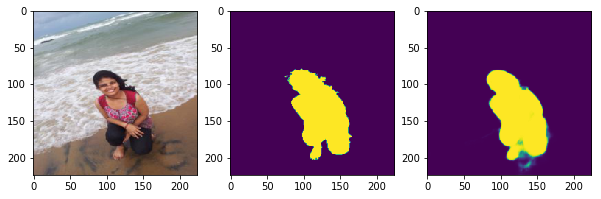

vgg16


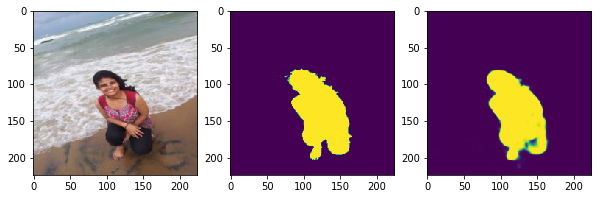

vgg19


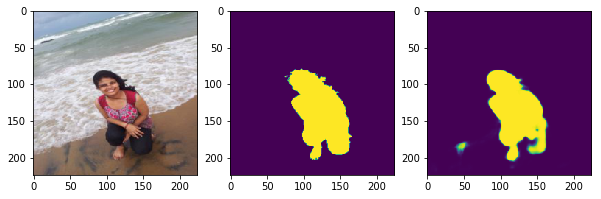

densenet121


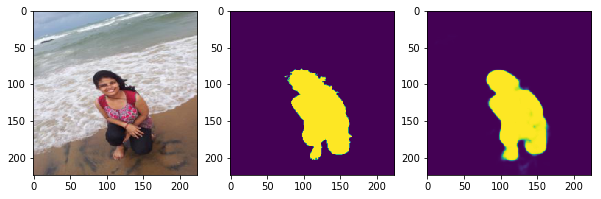

densenet201


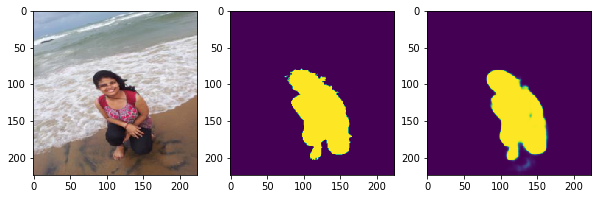

inceptionresnetv2


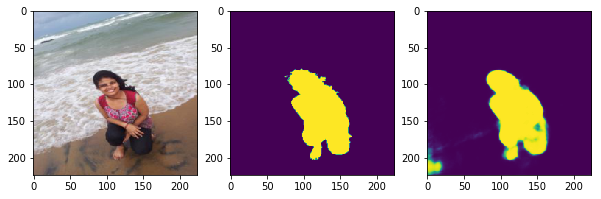

resnet18


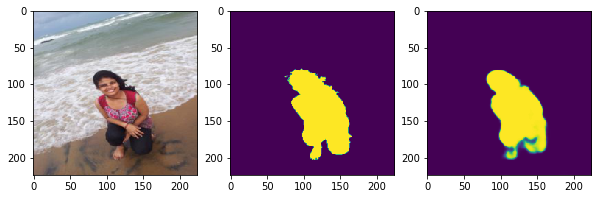

resnet50


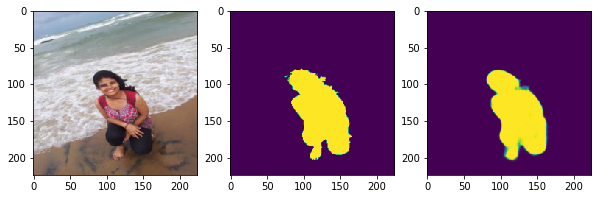

resnet152


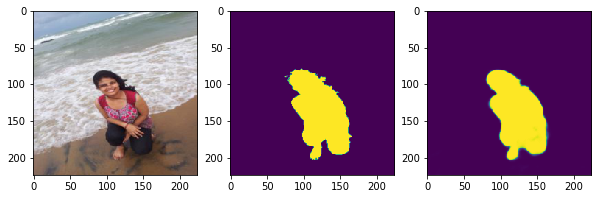

In [37]:
img, mask_true = test_data[indx]
for encoder in results:
    print(encoder)
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.subplot(132)
    plt.imshow(mask_true.squeeze().numpy())
    plt.subplot(133)
    plt.imshow(results[encoder]['pred'])
    plt.pause(0.1)

# LearningRate comparision

In [47]:
res=pd.DataFrame()
for lr in lr_results:
    lr_results[lr]
    
    d={'lr':lr}
    
    d['time']=lr_results[lr]['time']
    
    d.update({'train_'+k:v for k,v in sorted(lr_results[lr]['epochs'], key=lambda x: x['train']['f-score'], reverse=True)[0]['train'].items()})
    
    d.update({'valid_'+k:v for k,v in sorted(lr_results[lr]['epochs'], key=lambda x: x['valid']['f-score'], reverse=True)[0]['valid'].items()})
    
    d.update({'test_'+k:v for k,v in lr_results[lr]['test'].items()})
    
    res=res.append([d], ignore_index=True)

In [51]:
res[['lr', 'time', 
       'test_bce_loss',  'test_f-score',  'test_iou',
       'train_bce_loss', 'train_f-score', 'train_iou',
       'valid_bce_loss', 'valid_f-score', 'valid_iou']]

,lr,time,test_bce_loss,test_f-score,test_iou,train_bce_loss,train_f-score,train_iou,valid_bce_loss,valid_f-score,valid_iou
0,d 1e-3->1e-5 e 1e-5,0:06:01.323485,0.074587,0.976491,0.954784,0.044018,0.987729,0.975762,0.080204,0.977018,0.955103
1,d 1e-3 e 1e-5,0:06:01.808210,0.082261,0.977341,0.956475,0.029359,0.990412,0.981012,0.087005,0.977652,0.956310
2,d 1e-5 e 1e-5,0:06:02.391875,0.132972,0.965068,0.934281,0.102900,0.982432,0.965527,0.134263,0.968480,0.938921
3,d 1e-3 e 1e-3,0:06:02.546787,0.108741,0.964747,0.933974,0.039846,0.987493,0.975305,0.110900,0.970443,0.942663


d 1e-3->1e-5 e 1e-5


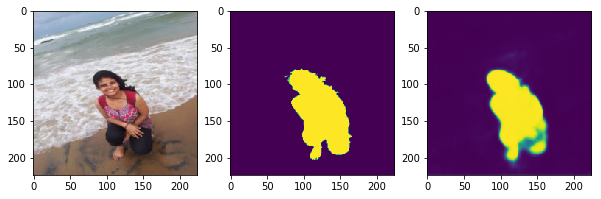

d 1e-3 e 1e-5


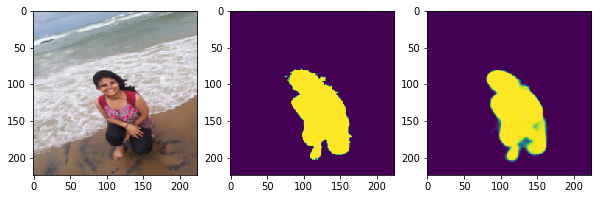

d 1e-5 e 1e-5


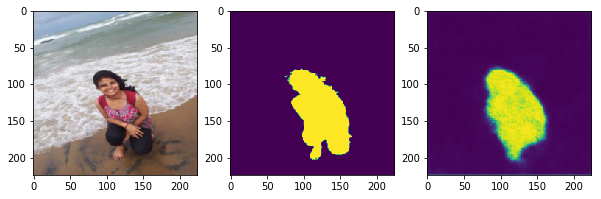

d 1e-3 e 1e-3


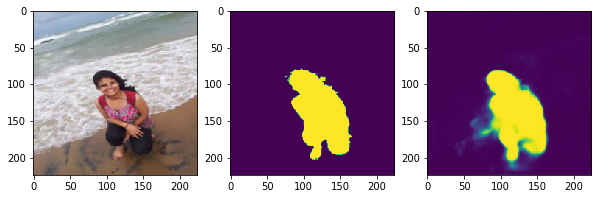

In [52]:
img, mask_true = test_data[indx]
for lr in lr_results:
    print(lr)
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.subplot(132)
    plt.imshow(mask_true.squeeze().numpy())
    plt.subplot(133)
    plt.imshow(lr_results[lr]['pred'])
    plt.pause(0.1)